In [69]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

#To see our directory
import os
import random
import gc   #Gabage collector for cleaning deleted data from memory

#1.Nacitajte data a pripravte ich na spracovanie
trainDataDir = "./train"
testDataDir = "./test"

test_imgs = ['./test/{}'.format(i)
             for i in os.listdir(testDataDir)]  # get test images

#random.shuffle(train)  # shuffle it randomly

# Image Parameters
SIZE = 32
N_CLASSES = 3  # CHANGE HERE, total number of classes
IMG_HEIGHT = 64  # CHANGE HERE, the image height to be resized to
IMG_WIDTH = 64  # CHANGE HERE, the image width to be resized to
CHANNELS = 3  # The 3 color channels, change to 1 if grayscale
batch_size = 32  # We will use a batch size of 32. Note: batch size should be a factor of 2.***4,8,16,32,64...***

categories = ["apple_pie", "baby_back_ribs", "caesar_salad", "caprese_salad",
              "chicken_quesadilla", "chicken_wings", "chocolate_cake", "cup_cakes", 
              "donuts", "dumplings", "french_fries", "garlic_bread",
              "grilled_salmon", "guacamole", "hamburger", "hot_dog",
              "ice_cream", "lasagna", "macaroni_and_cheese", "macarons",
              "onion_rings", "oysters", "pancakes", "pho",
              "pizza", "red_velvet_cake", "risotto", "sashimi", 
              "spaghetti_bolognese", "waffles", ]

selectedCategories = ["dumplings",
                      "french_fries",  "hamburger", "hot_dog"]


In [70]:
def image_resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation=inter)

    # return the resized image
    return resized


In [71]:
#A function to read and process the images to an acceptable format for our model
def read_and_process_image(dataPath, num):
    """
    Returns array of resized images
    """
    data = []  # images
    for img in os.listdir(dataPath):
        image = cv2.imread(os.path.join(dataPath, img))
        arr = cv2.resize(image, (SIZE, SIZE))
        arr = cv2.normalize(arr, arr, 0, 255, cv2.NORM_MINMAX)
        data.append([arr, num])

    return data


In [72]:
#NACITAME train a test data(jedla) a normalizujeme ich
train = []
test = []
X = []
y = []


for category in selectedCategories:
    trainPath = os.path.join(trainDataDir, category)
    testPath = os.path.join(testDataDir, category)
    num = selectedCategories.index(category)
    train = train + read_and_process_image(trainPath, num)
    test = test + read_and_process_image(testPath, num)

for t, label in train:
    X.append(t)
    y.append(label)
X = np.array(X).reshape(-1, SIZE, SIZE, 3)
y = np.array(y).reshape(-1, 1)
X.astype(float)
y.astype(float)

X_test = []
y_test = []
for t, label in test:
    X_test.append(t)
    y_test.append(label)

X_test = np.array(X_test).reshape(-1, SIZE, SIZE, 3)
#X_test.astype(float) / 255.0


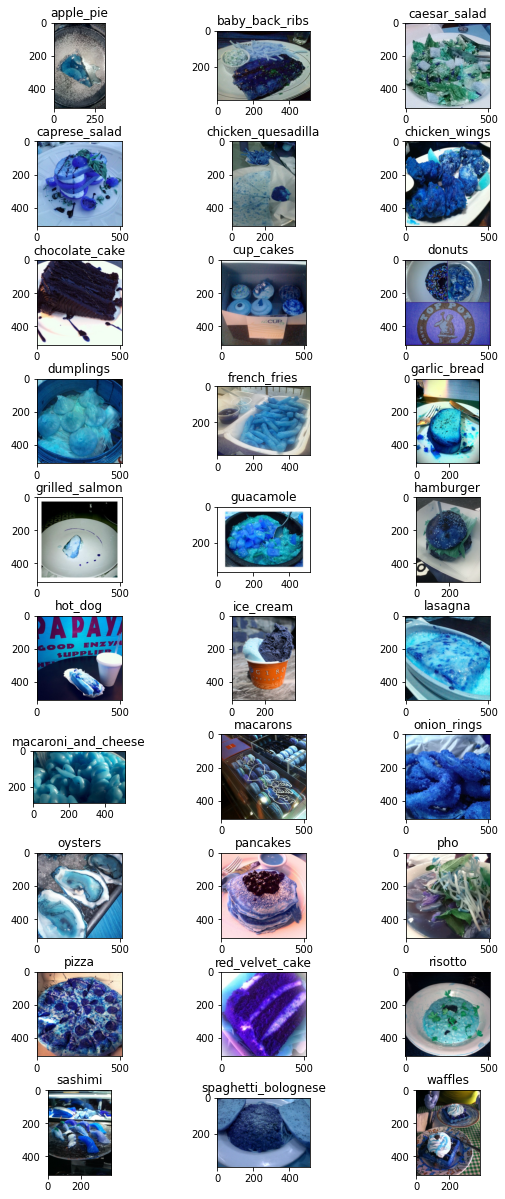

In [73]:
imgPrint = []
ctgry= []
fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 10
#Lets view some of the pics
def show_imgs():
    for i in range(1, columns*rows + 1):
        image = imgPrint[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(image)
        plt.title(ctgry[i-1])

    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                    bottom=1,
                    right=0.9,
                    top=3,
                    wspace=1,
                    hspace=0.4)
    plt.show()

#VYKRESLI 1 jedlo per kategoria
for category in categories:
    trainPath = os.path.join(trainDataDir, category)
    num = categories.index(category)
    for img in os.listdir(trainPath):
        images = cv2.imread(os.path.join(trainPath, img))
        # show_imgs(category, images)
        imgPrint.append(images)
        ctgry.append(category)
        break


show_imgs()


In [74]:

#Convert list to numpy array
# X = np.array(X)
# y = np.array(y)

# #Lets plot the label to be sure we just have two class
# sns.countplot(y)
# plt.title('Labels for Cats and Dogs')


In [75]:
print("Shape of train images is:", X.shape)
print("Shape of labels is:", y.shape)

Shape of train images is: (3600, 32, 32, 3)
Shape of labels is: (3600, 1)


In [76]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

#Now lets split our data into train and test
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=1)

Y_train = np_utils.to_categorical(y_train, 4)
Y_test = np_utils.to_categorical(y_test, 4)

print(Y_train)


[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


In [77]:
classes = np.unique(y_train)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  4
Output classes :  [0 1 2 3]


In [78]:
#clear memory
del X
del y
gc.collect()

#get the length of the train and validation data
ntrain = len(X_train)
nval = len(X_val)

Základny model

In [79]:
#Now lets create our model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

num_classes = np.unique(Y_train)
nClasses = len(num_classes)
# Determine shape of the data
img_width, img_height, img_num_channels = 32, 32, 3
input_shape = (img_width, img_height, img_num_channels)

# building a linear stack of layers with the sequential model
model = Sequential()

# convolutional layer
model.add(layers.Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(32, 32, 3)))

# convolutional layer
model.add(layers.Conv2D(75, kernel_size=(3, 3), strides=(
    1, 1), padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(125, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

# flatten output of conv
model.add(layers.Flatten())

# hidden layer
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(250, activation='relu'))
model.add(layers.Dropout(0.3))
# output layer
model.add(layers.Dense(4, activation='softmax'))


Model s regularizatormi

In [80]:
from keras.regularizers import l2

model2 = Sequential()

# convolutional layer
model2.add(layers.Conv2D(50, kernel_size=(3, 3), kernel_constraint=tf.keras.constraints.unit_norm(), kernel_regularizer=l2(0.01), strides=(1, 1),
                        padding='same', activation='relu', input_shape=(32, 32, 3)))

# convolutional layer
model2.add(layers.Conv2D(75, kernel_size=(3, 3), kernel_regularizer=l2(0.01), strides=(
    1, 1), padding='same', activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2, 2)))
model2.add(layers.Dropout(0.25))

model2.add(layers.Conv2D(125, kernel_size=(3, 3), kernel_regularizer=l2(0.01), strides=(
    1, 1), padding='same', activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2, 2)))
model2.add(layers.Dropout(0.25))

# flatten output of conv
model2.add(layers.Flatten())

# hidden layer
model2.add(layers.Dense(500, activation='relu'))
model2.add(layers.Dropout(0.4))
model2.add(layers.Dense(250, activation='relu'))
model2.add(layers.Dropout(0.2))
# output layer
model2.add(layers.Dense(4, activation='softmax'))


In [81]:
#Lets see our model
model.summary()

#Lets see our model
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 50)        1400      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 75)        33825     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 75)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 16, 16, 75)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 125)       84500     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 125)         0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 8, 8, 125)        

Augmentation pomocou ImageDataGenerator

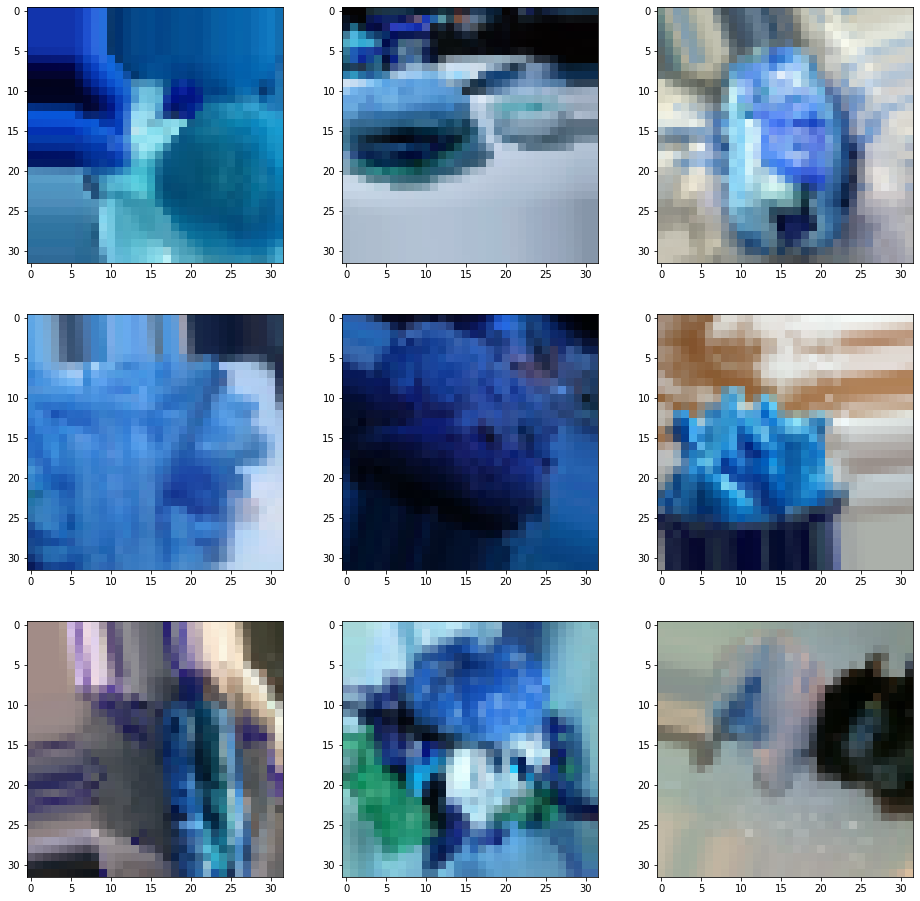

In [82]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# construct the training image generator for data augmentation
datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                         width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                         horizontal_flip=True, fill_mode="nearest")


datagen.fit(X_train)

fig = plt.figure(figsize=(16,16))
rows = 3
columns = 3
for X_batch, y_batch in datagen.flow(X_train, Y_train, batch_size=32):
    for i in range(1, rows*columns + 1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(X_batch[i]/255)
    break
plt.show()



Compile the Model

In [83]:

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
loss_function = categorical_crossentropy
optimizer = Adam()

# Compile the model
model2.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])


In [84]:
print("Shape of train images is:", X_train.shape)
print("Shape of labels is:", Y_train.shape)


Shape of train images is: (2880, 32, 32, 3)
Shape of labels is: (2880, 4)


In [85]:
# Fit data to model
history = model2.fit(X_train, Y_train,
            batch_size=batch_size,
            epochs=10,
            verbose=1,
            validation_data=(X_test, Y_test))


Epoch 1/10
 6/90 [=>............................] - ETA: 23s - loss: 1112.4819 - accuracy: 0.1875

KeyboardInterrupt: 

Evaluate the model

In [ ]:
# Generate generalization metrics
score = model2.evaluate(X_test, Y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Plot results and predictions

In [ ]:
ypred = model2.predict(X_train)
ypred = np.argmax(ypred, axis=1)

#lets plot the train and val curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model 2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for i in range(1, columns*rows + 1):
    image = X_train[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(image)
    xlabel = ''
    if selectedCategories[y_train[i-1][0]] == selectedCategories[ypred[i-1]]:
        xlabel = 'true'
    else: 
        xlabel = 'false'
    plt.xlabel(xlabel)
    plt.title(selectedCategories[ypred[i-1]])

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.4,
                    right=0.9,
                    top=1.5,
                    wspace=0.9,
                    hspace=0.4)
plt.show()


Predict the model

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# as I've trained my model on MNIST as odd or even (binary classes)
target_names = ['odd', 'even']

# get predict prob and label
ypred = model.predict(X_test)
# print(classification_report(np.argmax(Y_train, axis=1),
#                             ypred, target_names=target_names))


Trying to do confusion matrix but unsuccessfully. Maybe matrix dimension problem.

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

# y_categorial = np_utils.to_categorical(ypred, 4, dtype ="float32")
# y_pred = np.argmax(y_categorial, axis=1)

# print(y_categorial)
# print(Y_test)

# cm = confusion_matrix(np.argmax(Y_test, axis=1), y_categorial)
# cm = pd.DataFrame(cm, range(2), range(2))
# plt.figure(figsize=(10, 10))

# sns.heatmap(cm, annot=True, annot_kws={"size": 12})  # font size
# plt.show()


In [ ]:
from sklearn.decomposition import PCA

X_train = X_train.reshape(len(X_train), np.prod(X_train.shape[1:]))
X_test = X_test.reshape(len(X_test), np.prod(X_test.shape[1:]))

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_train)
principalDf = pd.DataFrame(data=principalComponents, columns=[
                           'principal component 1', 'principal component 2'])
y = pd.DataFrame(data=y_train)
finalDf = pd.concat([principalDf, y], axis=1)

plt.figure(figsize=(8, 8))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2', fontsize=15)
plt.title('component PCA', fontsize=20)
targets = [0, 1, 2, 3]
for target in targets:
    indicesToKeep = finalDf[0] == target
    plt.scatter(finalDf.loc[indicesToKeep, 'principal component 1'],
                finalDf.loc[indicesToKeep, 'principal component 2'], s=50)
plt.legend(categories)
plt.show()


In [ ]:
#3D vizualizacia
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
pca.fit(X_train)
components = pca.fit_transform(X_train)
result = pd.DataFrame(components, columns=['PCA%i' % i for i in range(3)])
finalDf2 = pd.concat([result, y], axis=1)

fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
for target in targets:
    indicesToKeep = finalDf2[0] == target
    ax.scatter(finalDf2['PCA0'], finalDf2['PCA1'], finalDf2['PCA2'], s=60, cmap=plt.cm.nipy_spectral,
               edgecolor='k')
ax.legend(categories)
# label the axes

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("PCA")
plt.show()
